# Exploring the reference database
Let's see what properties we can find :) <br>
Let's put more data into it !

## TODOs
 - scale frequency spectrum before
 - species level precision (instead of strand level)
 - automate all : 
  - PCA/LDA/Autoencoder/nothing
  - number of bacteria and samples
 - treat plasmids differently
 - try with real Nanopore reads
 - unsupervised learning on all windows into 10 bins ?
 - hierarchical clustering ??
 - clustering with minimal distance
 - taxo id to family or genus
 - tsne plot

## Structure
In `genome/`, there's multiple sub-folder, we will start with `Bacteria`
It then contains all recorded species/strands in individual folders


http://defindit.com/readme_files/ncbi_file_extension_format.html

What we need is the taxo id, name, and the DNA, which can be found in:
 - .gbk for the taxo and name
 - .fna for the sequence

## Coding
### Import and Paths

In [2]:
import os
import pandas as pd
import numpy as np
import pickle
from time import time
from tqdm import tqdm_notebook as tqdm

In [1]:
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = 13, 8

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
path_ref_db = "/mnt/genomeDB/ncbi/genomes/Bacteria/"
path_kmer_freq = "/home/sjriondet/Data/Kmer_frequencies/"

In [6]:
path_4mer = "4_V3/"
path_4mer = os.path.join(path_kmer_freq, path_4mer)

In [7]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers.largepd")
path_all

'/home/sjriondet/Data/Kmer_frequencies/4_V3/_all_bacteria_4mers.largepd'

## Main dataset

Load the whole dataset. Will take a while !!

In [8]:
all_all_df = pd.read_pickle(path_all)

In [9]:
cols_kmers = all_all_df.columns.to_list()[4:]

In [11]:
cols_spe = sorted(list(set(all_all_df.columns.to_list()).difference(set(cols_kmers))))

In [12]:
all_all_df.sample(5)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
745,Escherichia_coli_W_uid162011,NC_017635,4900968,745000,3,6,3,3,5,3,...,5,5,6,6,2,4,3,6,7,14
1364,Francisella_cf__novicida_Fx1_uid162105,NC_017450,1913619,1364000,11,3,2,7,1,4,...,1,12,9,9,2,6,15,8,14,26
256,Pseudomonas_fluorescens_CHA0_uid203393,NC_021237,6867980,256000,2,4,0,2,3,7,...,6,2,1,3,1,0,0,1,1,0
304,Thermotoga_RQ2_uid58935,NC_010483,1877693,304000,9,3,14,12,6,4,...,3,14,7,4,6,6,4,6,9,8
694,Chlorobium_tepidum_TLS_uid57897,NC_002932,2154946,694000,9,6,5,5,9,4,...,3,11,5,2,8,6,3,11,4,19


In [13]:
all_all_df.shape

(9620234, 260)

In [14]:
len(all_all_df.fna.unique())

5132

## Functions

In [22]:
n_samples = 100000
n_bacteria = 100

In [23]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [24]:
all_all_df.shape, all_df.shape

((9620234, 260), (100000, 260))

## PCA Principal Component Analysis
Reducing dimension from 256 to ~10

In [153]:
len(cols_kmers)

256

In [57]:
pca = PCA(n_components=50)
pca.fit(all_df[cols_kmers])

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

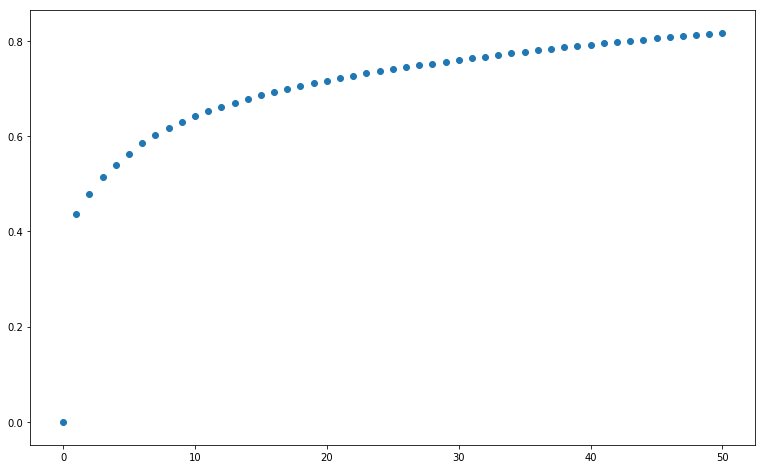

captured by PCA: 81.7%


In [58]:
plt.scatter(x=range(len(pca.explained_variance_ratio_)+1), 
            y=np.insert(pca.explained_variance_ratio_.cumsum(), 0, 0))
# plt.plot(pca.explained_variance_ratio_)
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_)*100:0.1f}%")

In [59]:
pca_n = 10

In [60]:
pca = PCA(n_components=pca_n)
pca.fit(all_df[cols_kmers])

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [61]:
np_pca = pca.transform(all_df[cols_kmers])

In [62]:
cols_pca = [f"pca_{i+1}" for i in range(pca_n)]

In [63]:
df_pca = pd.DataFrame(np_pca, columns=cols_pca)

In [64]:
df_pca = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_pca], axis=1) # , ignore_index=True)

In [65]:
df_pca

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10
0,Fluviicola_taffensis_DSM_16823_uid65271,NC_015321,4633577,4059000,49.10,-2.18,-3.40,-6.27,-1.49,1.68,-0.12,14.68,9.66,0.94
1,Riemerella_anatipestifer_RA_GD_uid162013,NC_017569,2166384,1258000,52.68,7.63,-16.90,3.57,5.25,-5.53,-5.41,-9.37,-1.08,-4.53
2,Burkholderia_gladioli_BSR3_uid66301,NC_015376,3700833,3479000,-51.96,14.90,-0.56,-4.62,-14.84,15.77,-4.10,-2.22,-1.27,-6.96
3,Zunongwangia_profunda_SM_A87_uid48073,NC_014041,5128187,1843000,40.76,-0.56,12.26,-1.41,-2.05,-4.70,-3.79,9.27,-2.15,-8.82
4,Vibrio_parahaemolyticus_RIMD_2210633_uid57969,NC_004605,1877212,950000,27.78,-9.56,-8.16,-7.16,0.71,-0.95,-1.04,-3.52,6.10,1.15
5,Xanthomonas_axonopodis_citrumelo_F1_uid73179,NC_016010,4967469,3428000,-37.47,4.79,0.36,-9.22,-5.70,1.94,-5.65,-0.69,-0.99,-3.35
6,Escherichia_coli_O55_H7_CB9615_uid46655,NC_013941,5386352,921000,6.28,-13.79,-7.88,-1.89,-1.28,-5.48,6.22,-2.75,1.27,-5.48
7,Zunongwangia_profunda_SM_A87_uid48073,NC_014041,5128187,1417000,61.84,12.40,18.43,2.48,4.28,3.05,1.74,3.49,-1.39,-2.01
8,Mycobacterium_canettii_CIPT_140070017_uid184830,NC_019952,4524466,16000,-29.77,-6.89,-1.43,2.94,10.29,-12.91,-10.99,-6.21,18.92,2.71
9,Streptococcus_thermophilus_MN_ZLW_002_uid166827,NC_017927,1848520,686000,24.49,-22.28,2.68,-10.70,4.17,-2.65,-2.24,-2.21,5.60,-1.50


In [66]:
df_pca["color_map"] = 0
for i, bacteria in enumerate(df_pca.bacteria.unique()):
    df_pca.loc[df_pca["bacteria"] == bacteria, ['color_map']] = i

In [67]:
df_pca.shape

(100000, 15)

In [68]:
df_pca

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,color_map
0,Fluviicola_taffensis_DSM_16823_uid65271,NC_015321,4633577,4059000,49.10,-2.18,-3.40,-6.27,-1.49,1.68,-0.12,14.68,9.66,0.94,0
1,Riemerella_anatipestifer_RA_GD_uid162013,NC_017569,2166384,1258000,52.68,7.63,-16.90,3.57,5.25,-5.53,-5.41,-9.37,-1.08,-4.53,1
2,Burkholderia_gladioli_BSR3_uid66301,NC_015376,3700833,3479000,-51.96,14.90,-0.56,-4.62,-14.84,15.77,-4.10,-2.22,-1.27,-6.96,2
3,Zunongwangia_profunda_SM_A87_uid48073,NC_014041,5128187,1843000,40.76,-0.56,12.26,-1.41,-2.05,-4.70,-3.79,9.27,-2.15,-8.82,3
4,Vibrio_parahaemolyticus_RIMD_2210633_uid57969,NC_004605,1877212,950000,27.78,-9.56,-8.16,-7.16,0.71,-0.95,-1.04,-3.52,6.10,1.15,4
5,Xanthomonas_axonopodis_citrumelo_F1_uid73179,NC_016010,4967469,3428000,-37.47,4.79,0.36,-9.22,-5.70,1.94,-5.65,-0.69,-0.99,-3.35,5
6,Escherichia_coli_O55_H7_CB9615_uid46655,NC_013941,5386352,921000,6.28,-13.79,-7.88,-1.89,-1.28,-5.48,6.22,-2.75,1.27,-5.48,6
7,Zunongwangia_profunda_SM_A87_uid48073,NC_014041,5128187,1417000,61.84,12.40,18.43,2.48,4.28,3.05,1.74,3.49,-1.39,-2.01,3
8,Mycobacterium_canettii_CIPT_140070017_uid184830,NC_019952,4524466,16000,-29.77,-6.89,-1.43,2.94,10.29,-12.91,-10.99,-6.21,18.92,2.71,7
9,Streptococcus_thermophilus_MN_ZLW_002_uid166827,NC_017927,1848520,686000,24.49,-22.28,2.68,-10.70,4.17,-2.65,-2.24,-2.21,5.60,-1.50,8


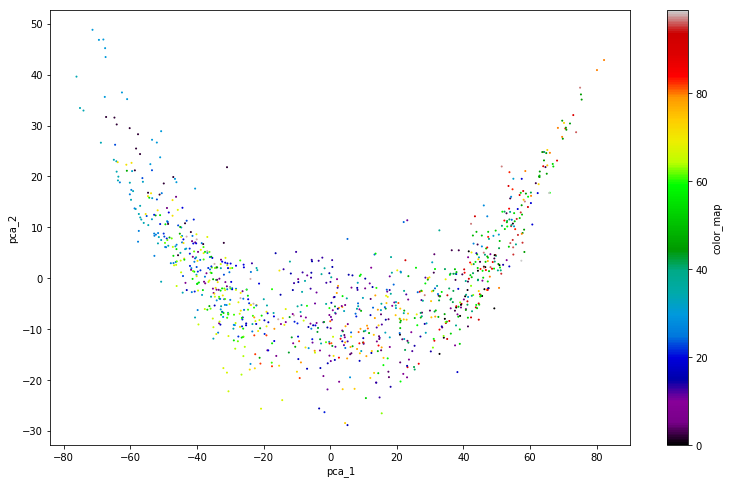

captured by PCA: 47.8%


In [70]:
df_pca.sample(1000).plot.scatter(x="pca_1", y="pca_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_[:2])*100:0.1f}%")

## LDA Linear Discriminant Analysis
Another dimension reduction

In [209]:
lda = LinearDiscriminantAnalysis(n_components=50)
lda.fit(all_df[cols_kmers], all_df.bacteria)
print(f"captured by LDA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

captured by PCA: 99.0%


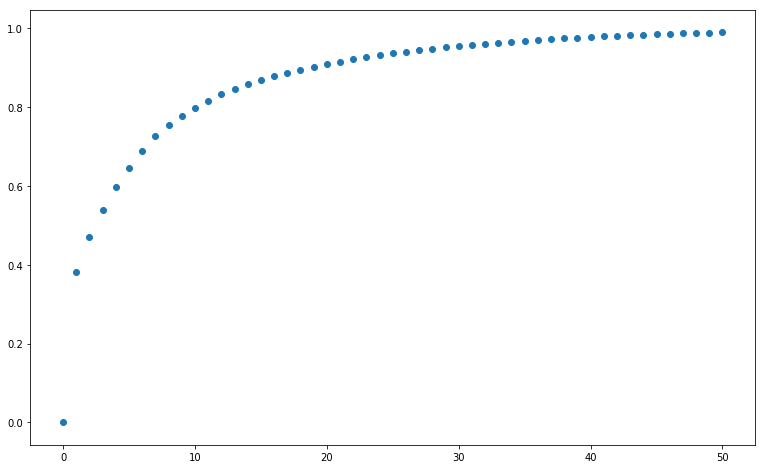

captured by LDA: 99.0%


In [217]:
plt.scatter(x=range(len(lda.explained_variance_ratio_)+1), 
            y=np.insert(lda.explained_variance_ratio_.cumsum(), 0, 0),)
plt.show()
print(f"captured by LDA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

In [223]:
{i+1: cum for i, cum in enumerate(lda.explained_variance_ratio_.cumsum())}

{1: 0.38161063997051536,
 2: 0.47160826886752261,
 3: 0.53999138455250617,
 4: 0.59700759401305381,
 5: 0.64534682262646581,
 6: 0.68846531995885452,
 7: 0.7258672104802788,
 8: 0.75486142332687678,
 9: 0.77796522005679247,
 10: 0.79858737725335149,
 11: 0.81670576833561292,
 12: 0.8327964639689609,
 13: 0.84723766672118983,
 14: 0.85876128959084852,
 15: 0.86949855742718341,
 16: 0.87930183402758155,
 17: 0.88741872127301746,
 18: 0.89527116586557054,
 19: 0.90263550527091574,
 20: 0.90966768393575936,
 21: 0.91567748867506527,
 22: 0.92158703507491335,
 23: 0.92722137275026606,
 24: 0.93196555879165222,
 25: 0.93646776516205643,
 26: 0.94068094474543074,
 27: 0.9447374148997375,
 28: 0.94850343795741154,
 29: 0.95209645454737013,
 30: 0.9553326810876458,
 31: 0.95837233501174046,
 32: 0.96132278435357976,
 33: 0.96399373034031499,
 34: 0.96655263136477243,
 35: 0.96889774088378622,
 36: 0.97105054727527651,
 37: 0.97297875845683235,
 38: 0.97478892803551664,
 39: 0.97656515263860588,

In [229]:
lda_n = 40

In [230]:
lda = LinearDiscriminantAnalysis(n_components=lda_n)
lda.fit(all_df[cols_kmers], all_df.bacteria)
print(f"captured by PCA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

captured by PCA: 97.8%


In [231]:
np_lda = lda.transform(all_df[cols_kmers])

In [232]:
cols_lda = [f"lda_{i+1}" for i in range(lda_n)]

In [233]:
df_lda = pd.DataFrame(np_lda, columns=cols_lda)

In [234]:
df_lda = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_lda], axis=1) # , ignore_index=True)

In [235]:
df_lda

,bacteria,fna,len_genome,start,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,...,lda_31,lda_32,lda_33,lda_34,lda_35,lda_36,lda_37,lda_38,lda_39,lda_40
0,Magnetospirillum_magneticum_AMB_1_uid58527,NC_007626,4967148,3288000,5.11,2.81,1.76,1.62,0.56,2.00,...,-0.43,-1.49,0.29,0.19,-0.34,-0.91,-0.74,-0.04,1.01,-0.57
1,Actinosynnema_mirum_DSM_43827_uid58951,NC_013093,8248144,4905000,6.13,6.05,0.39,0.04,-1.44,3.47,...,-1.37,1.04,1.22,-1.06,-0.42,-0.68,-1.09,1.04,1.14,-1.19
2,Pseudogulbenkiania_NH8B_uid73423,NC_016002,4332995,55000,3.14,0.21,1.90,0.64,-0.31,1.55,...,0.39,0.53,0.00,-0.34,-0.23,0.01,0.27,0.09,-0.40,0.95
3,Thermus_CCB_US3_UF1_uid81197,NC_017278,2243772,1540000,3.24,11.44,10.06,1.20,0.95,-1.70,...,0.05,-0.71,1.03,0.80,0.35,0.88,2.33,-0.76,0.59,1.11
4,Thermus_CCB_US3_UF1_uid81197,NC_017278,2243772,393000,2.87,5.36,3.47,0.54,0.76,-1.33,...,-0.23,2.78,1.96,1.07,-0.33,2.05,-1.30,0.13,-0.61,-1.02
5,Rickettsia_prowazekii_BuV67_CWPP_uid158063,NC_017056,1111445,316000,-6.52,2.31,-2.56,2.67,-2.92,1.35,...,1.25,-1.33,1.72,-0.68,-0.21,0.72,0.85,-0.95,0.95,-0.05
6,Clostridium_botulinum_Ba4_657_uid59173,NC_012658,3977794,637000,-7.10,4.78,-2.36,4.57,-2.13,-2.03,...,0.27,0.74,-0.72,-0.88,-1.27,0.58,-1.82,0.63,0.59,0.23
7,Methylibium_petroleiphilum_PM1_uid58085,NC_008825,4044195,3955000,5.70,-1.25,-3.38,3.48,2.27,1.66,...,-0.75,-0.79,2.29,-0.70,0.37,0.12,-0.07,1.51,-1.59,0.70
8,Magnetospirillum_magneticum_AMB_1_uid58527,NC_007626,4967148,2125000,3.74,1.98,2.13,1.07,-0.65,1.64,...,-0.16,1.03,0.87,-0.45,0.85,-1.96,-0.44,0.68,-1.04,-0.12
9,Prevotella_ruminicola_23_uid47507,NC_014033,3619559,587000,-1.18,-2.25,1.30,-0.33,-1.15,0.83,...,-1.00,0.05,-0.83,-0.50,0.65,-1.21,0.15,1.40,-0.99,-2.21


In [218]:
df_lda["color_map"] = 0
for i, bacteria in enumerate(df_lda.bacteria.unique()):
    df_lda.loc[df_lda["bacteria"] == bacteria, ['color_map']] = i

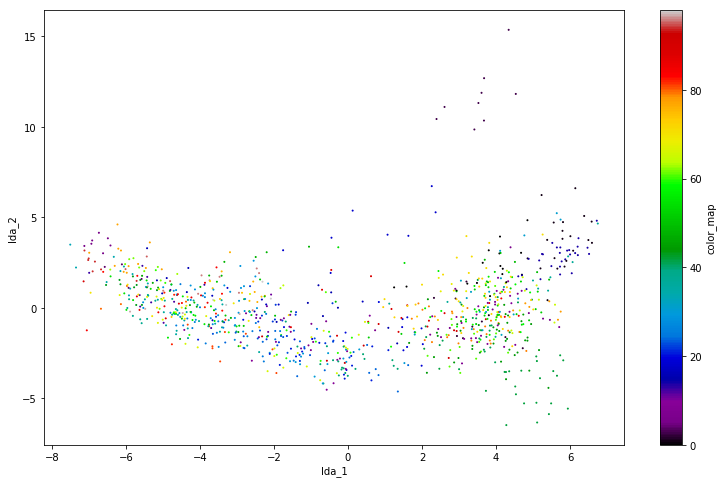

captured by LDA: 47.2%


In [220]:
df_lda.sample(1000).plot.scatter(x="lda_1", y="lda_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by LDA: {sum(lda.explained_variance_ratio_[:2])*100:0.1f}%")

## Machine Learning classification

In [72]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [149]:
cols_spe

['bacteria', 'fna', 'len_genome', 'start']

In [236]:
# With LDA
X_train, X_test, y_train, y_test = train_test_split(scale(df_lda[cols_pca]), df_lda.bacteria, 
                                                    test_size=0.1, random_state=0)

In [237]:
models = {
    "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6),
    "SVM_lin": SVC(kernel="linear", C=0.025),
    "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),
    "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=6),
    "DTree": DecisionTreeClassifier(max_depth=20),
    "NNet": MLPClassifier(alpha=1),
#     "AdaBoost": AdaBoostClassifier(),  # worse classifier
    "Naive_Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [238]:
results = {}

In [239]:
for name in tqdm(models.keys()):
    if name not in results.keys():
        print(name)
        start = time()
        results[name] = {}
        
        models[name].fit(X_train, y_train)
        time_fitted = time()
        results[name]["time_fit"] = time_fitted - start
        
        predicted = models[name].predict(X_test)
        results[name]["predicted"] = predicted
        time_predicted = time()
        results[name]["time_predict"] = time_predicted - time_fitted
        
#         score = models[name].score(X_test, y_test)
#         results[name]["score"] = score
#         results[name]["time_score"] = time() - time_predicted
        
        results[name]["time"] = time() - start
    

RF
SVM_lin
SVM_rbf
KNeigh
DTree
NNet
Naive_Bayes
QDA



In [240]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [241]:
name_run = f"_LDA40_{n_samples}samples_{n_bacteria}bac"

`name_run = f"_LDA-40_{n_samples}-samples_{n_bacteria}-bac"`

In [242]:
if True:
    for model in tqdm(models.keys()):
        with open(os.path.join(path_models, f"_{model}_{name_run}.pkl"), 'wb') as f_out:
            pickle.dump(models[model], f_out)

In [243]:
to_df = {"Ground_Truth": y_test}
for name in results.keys():
    predicted = results[name]["predicted"]
    to_df[f"{name}"] = (y_test==predicted).astype(int)
    to_df[f"{name}_pred"] = predicted
pd_res = pd.DataFrame(to_df)

pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [244]:
ranking = 100 * pd_res.sum(numeric_only=True) / pd_res.RF.count()

In [245]:
pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                           "percentage": ranking.values})

In [247]:
for times in ("time", "time_fit", "time_predict", ):
    pd_ranking[times] = 0
    for name in results.keys():
        pd_ranking.loc[pd_ranking["name"] == name, [times]] = results[name][times]

In [249]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking

,name,percentage,time,time_fit,time_predict,time_score
2,SVM_rbf,55.64,237.71,115.49,122.22,0
7,QDA,54.91,0.34,0.23,0.12,0
1,SVM_lin,54.42,172.08,57.64,114.44,0
0,RF,53.90,17.95,17.63,0.31,0
6,Naive_Bayes,52.76,0.44,0.34,0.10,0
3,KNeigh,52.39,2.48,0.20,2.28,0
5,NNet,52.12,125.56,125.51,0.05,0
4,DTree,42.26,5.01,5.01,0.01,0


## Saved results for various input settings

Results for 100,000 samples from 100 species, NO PCA, 256 features

In [178]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

,name,percentage,time,time_fit,time_predict
2,SVM_rbf,70.33,"1,668.93",933.08,368.16
1,SVM_lin,68.31,990.75,422.66,283.68
5,NNet,68.02,357.47,357.29,0.10
3,KNeigh,61.02,283.34,3.41,142.12
7,Naive_Bayes,57.80,4.42,0.66,1.89
0,RF,54.40,19.98,19.15,0.41
8,QDA,29.86,13.22,4.96,4.13
4,DTree,28.53,19.70,19.66,0.01
6,AdaBoost,6.02,108.24,103.04,2.60


Results for 100,000 samples from 100 species, LDA, 40 features

In [248]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

,name,percentage,time,time_fit,time_predict,time_score
2,SVM_rbf,55.64,237.71,115.49,122.22,0
7,QDA,54.91,0.34,0.23,0.12,0
1,SVM_lin,54.42,172.08,57.64,114.44,0
0,RF,53.90,17.95,17.63,0.31,0
6,Naive_Bayes,52.76,0.44,0.34,0.10,0
3,KNeigh,52.39,2.48,0.20,2.28,0
5,NNet,52.12,125.56,125.51,0.05,0
4,DTree,42.26,5.01,5.01,0.01,0


Results for 100,000 samples from 100 species, LDA, 10 features

In [198]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

,name,percentage,time,time_fit,time_predict,time_score
2,SVM_rbf,55.64,363.89,118.56,123.00,122.33
7,QDA,54.91,0.48,0.23,0.12,0.13
1,SVM_lin,54.42,290.47,59.57,115.46,115.44
0,RF,53.90,18.46,17.73,0.41,0.32
5,NNet,52.99,141.48,141.37,0.05,0.06
6,Naive_Bayes,52.76,0.57,0.35,0.10,0.12
3,KNeigh,52.39,7.91,0.21,3.90,3.80
4,DTree,42.14,5.13,5.10,0.01,0.02


Results for 100,000 samples from 100 species, with PCA, 10 features

In [95]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

,name,percentage,time
2,SVM_rbf,46.72,448.23
8,QDA,46.17,0.53
0,RF,44.11,18.23
1,SVM_lin,41.75,346.49
3,KNeigh,40.99,5.65
7,Naive_Bayes,39.55,0.60
5,NNet,38.76,84.88
4,DTree,32.99,5.01
6,AdaBoost,7.40,58.29


Results for 10,000 samples from 100 species, with PCA

In [52]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

,name,percentage,time
2,SVM_rbf,40.50,6.79
8,QDA,38.90,0.08
0,RF,38.80,1.78
5,NNet,38.10,26.52
7,Naive_Bayes,38.00,0.08
1,SVM_lin,33.20,4.46
3,KNeigh,31.10,0.49
4,DTree,26.70,0.39
6,AdaBoost,5.70,5.48


In [201]:
pd_res

,Ground_Truth,RF,RF_pred,SVM_lin,SVM_lin_pred,SVM_rbf,SVM_rbf_pred,KNeigh,KNeigh_pred,DTree,DTree_pred,NNet,NNet_pred,Naive_Bayes,Naive_Bayes_pred,QDA,QDA_pred
3582,Pseudomonas_aeruginosa_PAO581_uid219357,0,Methylobacterium_chloromethanicum_CM4_uid58933,0,Methylobacterium_chloromethanicum_CM4_uid58933,0,Methylobacterium_chloromethanicum_CM4_uid58933,0,Methylobacterium_chloromethanicum_CM4_uid58933,0,Sinorhizobium_meliloti_SM11_uid159685,0,Methylobacterium_chloromethanicum_CM4_uid58933,0,Methylobacterium_chloromethanicum_CM4_uid58933,0,Methylobacterium_chloromethanicum_CM4_uid58933
60498,Novosphingobium_PP1Y_uid67383,1,Novosphingobium_PP1Y_uid67383,1,Novosphingobium_PP1Y_uid67383,1,Novosphingobium_PP1Y_uid67383,1,Novosphingobium_PP1Y_uid67383,1,Novosphingobium_PP1Y_uid67383,1,Novosphingobium_PP1Y_uid67383,1,Novosphingobium_PP1Y_uid67383,1,Novosphingobium_PP1Y_uid67383
53227,Chamaesiphon_minutus_PCC_6605_uid183005,1,Chamaesiphon_minutus_PCC_6605_uid183005,1,Chamaesiphon_minutus_PCC_6605_uid183005,1,Chamaesiphon_minutus_PCC_6605_uid183005,1,Chamaesiphon_minutus_PCC_6605_uid183005,0,Cyanothece_PCC_7822_uid52547,1,Chamaesiphon_minutus_PCC_6605_uid183005,1,Chamaesiphon_minutus_PCC_6605_uid183005,1,Chamaesiphon_minutus_PCC_6605_uid183005
21333,Chlorobaculum_parvum_NCIB_8327_uid59185,1,Chlorobaculum_parvum_NCIB_8327_uid59185,0,Sinorhizobium_meliloti_SM11_uid159685,0,Sinorhizobium_meliloti_SM11_uid159685,0,Sinorhizobium_meliloti_SM11_uid159685,1,Chlorobaculum_parvum_NCIB_8327_uid59185,0,Sinorhizobium_meliloti_SM11_uid159685,0,Sinorhizobium_meliloti_SM11_uid159685,1,Chlorobaculum_parvum_NCIB_8327_uid59185
3885,Sinorhizobium_meliloti_SM11_uid159685,0,Novosphingobium_PP1Y_uid67383,0,Novosphingobium_PP1Y_uid67383,0,Novosphingobium_PP1Y_uid67383,0,Novosphingobium_PP1Y_uid67383,0,Novosphingobium_PP1Y_uid67383,0,Novosphingobium_PP1Y_uid67383,0,Novosphingobium_PP1Y_uid67383,0,Novosphingobium_PP1Y_uid67383
51521,Chlorobaculum_parvum_NCIB_8327_uid59185,1,Chlorobaculum_parvum_NCIB_8327_uid59185,0,Sinorhizobium_meliloti_SM11_uid159685,1,Chlorobaculum_parvum_NCIB_8327_uid59185,0,Sinorhizobium_meliloti_SM11_uid159685,0,Cryptobacterium_curtum_DSM_15641_uid59041,0,Sinorhizobium_meliloti_SM11_uid159685,1,Chlorobaculum_parvum_NCIB_8327_uid59185,1,Chlorobaculum_parvum_NCIB_8327_uid59185
84261,Escherichia_coli_SE11_uid59425,0,Escherichia_coli_O7_K1_CE10_uid162115,0,Salmonella_enterica_serovar_Bovismorbificans_3...,0,Salmonella_enterica_serovar_Bovismorbificans_3...,0,Salmonella_enterica_serovar_Paratyphi_A_AKU_12...,0,Salmonella_enterica_serovar_Bovismorbificans_3...,0,Salmonella_enterica_serovar_Bovismorbificans_3...,0,Salmonella_enterica_serovar_Bovismorbificans_3...,0,Salmonella_enterica_serovar_Bovismorbificans_3...
10685,Fluviicola_taffensis_DSM_16823_uid65271,1,Fluviicola_taffensis_DSM_16823_uid65271,1,Fluviicola_taffensis_DSM_16823_uid65271,1,Fluviicola_taffensis_DSM_16823_uid65271,1,Fluviicola_taffensis_DSM_16823_uid65271,1,Fluviicola_taffensis_DSM_16823_uid65271,1,Fluviicola_taffensis_DSM_16823_uid65271,1,Fluviicola_taffensis_DSM_16823_uid65271,1,Fluviicola_taffensis_DSM_16823_uid65271
59948,Mycobacterium_canettii_CIPT_140070017_uid184830,0,Mycobacterium_bovis_BCG_Mexico_uid86889,0,Mycobacterium_tuberculosis_RGTB327_uid157907,0,Mycobacterium_tuberculosis_RGTB327_uid157907,0,Mycobacterium_bovis_BCG_Mexico_uid86889,0,Mycobacterium_bovis_BCG_Mexico_uid86889,1,Mycobacterium_canettii_CIPT_140070017_uid184830,0,Mycobacterium_tuberculosis_uid185758,0,Mycobacterium_tuberculosis_uid185758
41032,Thermus_CCB_US3_UF1_uid81197,1,Thermus_CCB_US3_UF1_uid81197,1,Thermus_CCB_US3_UF1_uid81197,1,Thermus_CCB_US3_UF1_uid81197,1,Thermus_CCB_US3_UF1_uid81197,1,Thermus_CCB_US3_UF1_uid81197,1,Thermus_CCB_US3_UF1_uid81197,1,Thermus_CCB_US3_UF1_uid81197,1,Thermus_CCB_US3_UF1_uid81197


In [97]:
all_df.sample(5)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
1313,Pseudogulbenkiania_NH8B_uid73423,NC_016002,4332995,1313000,3,2,0,2,2,2,...,4,2,4,8,6,4,0,3,3,0
927,Francisella_tularensis_holarctica_FSC200_uid54341,NC_019551,1894157,927000,6,7,5,7,4,3,...,3,4,14,5,5,16,15,10,16,41
626,Dehalococcoides_VS_uid42393,NC_013552,1413462,626000,11,6,12,10,2,5,...,1,8,7,4,7,3,4,9,6,12
5,Clostridium_botulinum_Ba4_657_uid59173,NC_012654,270022,5000,20,7,4,21,8,0,...,0,16,6,2,2,8,20,11,9,18
653,Salmonella_enterica_serovar_Bovismorbificans_3...,NC_022241,4677483,653000,8,5,7,6,2,7,...,3,3,1,1,3,1,6,9,2,7


In [100]:
all_df[all_df.fna.str.contains("NC")].shape

(100000, 260)

In [111]:
all_df.loc[all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"), "fna"].unique()

[NC_022241, NC_022248]
Categories (2, object): [NC_022241, NC_022248]

In [123]:
all_df[(all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"))].len_genome.unique()

array([4677483,   93046])

In [124]:
y_test

['Pseudomonas_aeruginosa_PAO581_uid219357',
 'Mycobacterium_tuberculosis_RGTB327_uid157907',
 'Rickettsia_massiliae_AZT80_uid86751',
 'Francisella_tularensis_holarctica_FSC200_uid54341',
 'Mycobacterium_abscessus_uid61613',
 'Salmonella_enterica_serovar_Bovismorbificans_3114_uid218006',
 'Magnetospirillum_magneticum_AMB_1_uid58527',
 'Geobacter_sulfurreducens_KN400_uid161977',
 'Corynebacterium_halotolerans_YIM_70093___DSM_44683_uid189953',
 'Chamaesiphon_minutus_PCC_6605_uid183005',
 'Burkholderia_pseudomallei_668_uid58389',
 'Helicobacter_pylori_SouthAfrica20_uid216150',
 'Escherichia_coli_O7_K1_CE10_uid162115',
 'Acidithiobacillus_ferrooxidans_ATCC_23270_uid57649',
 'Fluviicola_taffensis_DSM_16823_uid65271',
 'Escherichia_coli_O55_H7_CB9615_uid46655',
 'Actinoplanes_friuliensis_DSM_7358_uid226110',
 'Escherichia_coli_O55_H7_CB9615_uid46655',
 'Cyanothece_PCC_7822_uid52547',
 'Francisella_tularensis_holarctica_FSC200_uid54341',
 'Bacillus_cytotoxicus_NVH_391_98_uid58317',
 'Zunongwan

In [125]:
df_pca1000.bacteria

0                  Fluviicola_taffensis_DSM_16823_uid65271
1                 Riemerella_anatipestifer_RA_GD_uid162013
2                      Burkholderia_gladioli_BSR3_uid66301
3                    Zunongwangia_profunda_SM_A87_uid48073
4            Vibrio_parahaemolyticus_RIMD_2210633_uid57969
5             Xanthomonas_axonopodis_citrumelo_F1_uid73179
6                  Escherichia_coli_O55_H7_CB9615_uid46655
7                    Zunongwangia_profunda_SM_A87_uid48073
8          Mycobacterium_canettii_CIPT_140070017_uid184830
9          Streptococcus_thermophilus_MN_ZLW_002_uid166827
10                 Escherichia_coli_O55_H7_CB9615_uid46655
11                           Aquifex_aeolicus_VF5_uid57765
12                 Fluviicola_taffensis_DSM_16823_uid65271
13                   Escherichia_coli_O7_K1_CE10_uid162115
14                     Burkholderia_gladioli_BSR3_uid66301
15                          Escherichia_coli_SE11_uid59425
16                           Psychrobacter_PRwf_1_uid584



### End of the script.
Sylvain @GIS

## Keep other methods

ML stuff

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [198]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [9]:
def normalise_counts(kmer_count):
    """Nested dict, normalize each of the sub dict. """
    for window in kmer_count.keys():
        max_val = max(kmer_count[window].values())
        for key in kmer_count[window]:
            kmer_count[window][key] /= max_val